# COGS 108 - Final Project 

# Overview

Our project aims to examine the correlations between tsunami strength and frequency and global warming. We utilized tsunami data and global temperature data to answer this research question. In conclusion, our initial hypothesis was disproved and we found that there is no correlation between strength and frequency and global warming. 

# Names

- Lucy Cummings
- Leanne Go
- Vicky Ly
- Alex Lui
- Bryce Bixler

# Group Members IDs

- A13565748
- A12730686
- A13602360
- A11883843 
- A12826238

# Research Question

How has global warming affected the strength of tsunamis in East and Southeast Asia?
How has global warming affected the frequency of tsunamis occurring in East and Southeast Asia?

## Background and Prior Work

As a group, we are all well aware of the seriousness of climate change and the effect it has on the Earth, such as rising temperatures, sea level rise, and increased droughts and heat waves in some parts of the world. Therefore, we wanted to conduct this research project to analyze how the seriousness of climate change affects tsunamis in East and Southeast Asia.

In recent times, there have been studies correlating climate change effects with natural disasters. A study from the Geophysical Fluid Dynamics Laboratory has found that tropical cyclone intensity will likely increase as global warming increases. [1] However, in terms of attributing these increases to humans, the study’s findings are much more inconclusive. According to the GFDL, it’s much harder to say for sure that humans are the cause of cyclone intensity increase. Although, there are studies that show that the increase of intensification is highly unusual compared to how intensification would normally increase. The Center for Climate and Energy Solutions  (C2ES) has also predicted that hurricane intensity will increase. [2] Similar to the GFDL study, the C2ES states that this is due to warmer ocean temperatures and sea level, but they can’t say for sure that these changes will cause an increase in the number of hurricanes.

In conclusion, it’s pretty clear that tropical storm intensity has and will continue to increase. 

We are interested in investigating whether sea level rise and warmer ocean temperatures may have an effect on other water-related natural disasters, in particular, tsunamis. Tsunamis are caused by underwater earthquakes along plate boundaries of the sea floor. [3] Most of them happen around East and Southeast Asia where the tectonic plates are particularly active. Despite being caused by undersea earthquakes, we were wondering if the rising sea levels might impact the strength and/or frequency of the tsunamis by affecting the water in this area. 

References (include links):
- 1)https://www.gfdl.noaa.gov/global-warming-and-hurricanes/
- 2)https://www.c2es.org/content/hurricanes-and-climate-change/
- 3)https://www.nationalgeographic.com/environment/natural-disasters/tsunamis/

# Hypothesis


We hypothesize that global warming is correlated to an increase in the strength and frequency of tsunamis in East and Southeast Asia. Our hypothesis is built on our knowledge from different news outlets we encounter in our daily lives and hearing about weather events worsening specifically hearing about record breaking tsunamis in recent times. 

# Dataset(s)



If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

Dataset Name: Tsunami Data
Link to Dataset: https://www.ngdc.noaa.gov/nndc/struts/form?t=101650&s=70&d=7
Number of Observations: 2400
This dataset contains information on tsunamis from 2000 B.C. to the present, including tsunami intensity, location, and number of deaths.

Dataset Name: Global Temperature Time Series
Link to Dataset: https://datahub.io/core/global-temp
Number of Observations: 2000
There are two datasets from this source. However we will be only using the first, which includes the global monthly mean temperature.

Dataset Name: Sea Level
Link to Dataset: https://climate.nasa.gov/vital-signs/sea-level/
Number of Observations: 960
This source also includes two datasets. We will only be using the first, which tracks sea level change since 1993.




# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

import os
import sys
import json

TsunamiData = pd.read_csv('TsunamiData.csv', encoding = 'latin')

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data Cleaning

The tsunami dataset is cleaned so that only events with a definate time, place, magnitude, and cause are included.

In [2]:
TsunamiData = TsunamiData[~TsunamiData[['YEAR', 'MONTH', 'COUNTRY', 'LATITUDE', 'LONGITUDE', 
                                        'MAXIMUM_WATER_HEIGHT', 'CAUSE_CODE']].isnull().any(axis = 1)]
TsunamiData['MAXIMUM_WATER_HEIGHT10'] = np.log10(TsunamiData['MAXIMUM_WATER_HEIGHT'])

year_array = np.array(TsunamiData['YEAR'].values) + np.array(TsunamiData['MONTH'].values)/12.0
height_array = np.array(TsunamiData['MAXIMUM_WATER_HEIGHT'].values)
height_array10 = np.array(TsunamiData['MAXIMUM_WATER_HEIGHT10'])

The sea level dataset was cleaned by removing a lot of the other measured factors from the dataframe and instead only keeping the columns outlined below. The column 'dif(mm)' was then created from the data and gives the difference in sea level since the first data point in January 1993 (instead of the mean between 1996-2016).

In [3]:
s = pd.read_csv("Datasets/SL.txt", delim_whitespace=True, header=None)
s.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
s = s[['1', '3', '4', '5', '12', '10']]
s.columns = ["alt type", "year+fraction", "# observations", "# weighted observations","smoothed w/ sig removed GMSL", "SD of GMSL"]
s['dif(mm)'] = s['smoothed w/ sig removed GMSL'] + 37.55

# Data Analysis & Results

## Testing for Normality
An implicit assumption in many statistics is that the data is normally distributed. The following cell shows that, to an alpha value of $0.05$, the distribution of $log_{10}$ maximum wave height is normally distributed. Therefore we are free to run our statistical tests on this data.

In [4]:
st_height10, p_height10 = stats.normaltest(height_array10)

alpha = 0.01
if p_height10 < alpha:
    print('The distribution of log(wave height) is normally distributed')
    print('p-value:', p_height10)
    print('median value:', np.median(height_array), '\tmean value:', np.mean(height_array))
else:
    print('The distribution of log(wave height) is not normally distributed')
    print('p-value:', p_height10)
    print('median value:', np.median(height_array), '\tmean value:', np.mean(height_array))

The distribution of log(wave height) is normally distributed
p-value: 0.00265169887967
median value: 1.0 	mean value: 6.17280418251


As a visual aid, the cell below plots a histogram of the $log_{10}$ maximum wave height data as well as the fitted normal curve. You will notice that there is a peak in the distribution at $10^{-1}$ meters. We hypothesize that this peak is due to the specific way in which the data was recorded. If there was a measurement uncertainty in the height of the Tsunami wave the default entry value could be $10^{-1}$ meters.

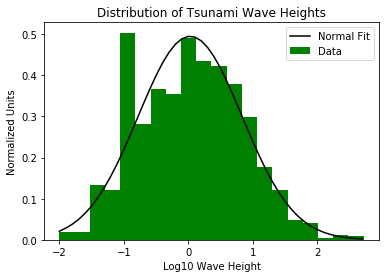

In [5]:
xs = np.arange(height_array10.min(), height_array10.max(), 0.1)
fit = stats.norm.pdf(xs, np.mean(height_array10), np.std(height_array10))
plt.plot(xs, fit, label='Normal Fit', color = 'black')
plt.hist(height_array10, density=True, label='Data', bins = 20, color = 'green')
plt.xlabel('Log10 Wave Height')
plt.ylabel('Normalized Units')
plt.title('Distribution of Tsunami Wave Heights')
plt.legend()
plt.show()

## Bar Graph of where Tsunami's have Occured
Below is a simple bar graph showing the number of tsunami's that have occured in each country. For simplicity, only countries with ten or more data points have been included.

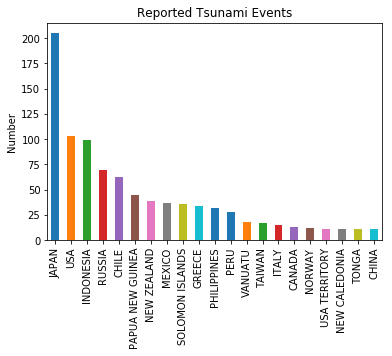

In [6]:
TsunamiValueCounts = TsunamiData['COUNTRY'].value_counts()
TsunamiValueCounts[TsunamiValueCounts > 10].plot(kind = 'bar')
plt.ylabel('Number')
plt.title('Reported Tsunami Events')
plt.show()

## Linear Regression
Below we perform a linear regression on the data, predicting $log_{10}$ maximum Tsunami wave height from the year the Tsunami occured.

In [7]:
outcome_Tsunami, predictors_Tsunami = patsy.dmatrices('MAXIMUM_WATER_HEIGHT10 ~ YEAR', TsunamiData)
mod_Tsunami = sm.OLS(outcome_Tsunami, predictors_Tsunami)
res_Tsunami = mod_Tsunami.fit()

print(res_Tsunami.summary())

                              OLS Regression Results                              
Dep. Variable:     MAXIMUM_WATER_HEIGHT10   R-squared:                       0.102
Model:                                OLS   Adj. R-squared:                  0.101
Method:                     Least Squares   F-statistic:                     119.1
Date:                    Sun, 09 Jun 2019   Prob (F-statistic):           2.48e-26
Time:                            23:56:39   Log-Likelihood:                -1209.5
No. Observations:                    1052   AIC:                             2423.
Df Residuals:                        1050   BIC:                             2433.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

Below we make a plot of the data with the regression line. The dotted lines represent the regression line with all its coefficients plus/minus two standard deviations.

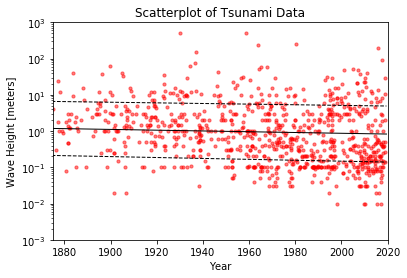

The regression line has a negative slope of -0.0025 with a standard error smaller than 0.0001.

From this anlysis we have failed to reject the null hypothesis and therefore cannot conclude that Tsunami wave height has 
increased over time.


In [8]:
xrange = np.arange(1400,2020,0.5)
ypred = np.exp(res_Tsunami.params[0] + res_Tsunami.params[1]*xrange)
ypred_upper = np.exp(res_Tsunami.params[0]+2*res_Tsunami.bse[0] + (res_Tsunami.params[1]+2*res_Tsunami.bse[1])*xrange)
ypred_lower = np.exp(res_Tsunami.params[0]-2*res_Tsunami.bse[0] + (res_Tsunami.params[1]-2*res_Tsunami.bse[1])*xrange)

plt.scatter(year_array, height_array, s = 10, alpha = 0.5, color = 'red')
plt.plot(xrange, ypred, color = 'black', lw = 1)
plt.plot(xrange, ypred_upper, color = 'black', ls = '--', lw = 1)
plt.plot(xrange, ypred_lower, color = 'black', ls = '--', lw = 1)
plt.yscale('log')
plt.xlim(1875,2020)
plt.ylim(10**-3, 10**3)
plt.xlabel('Year')
plt.ylabel('Wave Height [meters]')
plt.title('Scatterplot of Tsunami Data')
plt.show()
print('The regression line has a negative slope of -0.0025 with a standard error smaller than 0.0001.\n')
print('From this anlysis we have failed to reject the null hypothesis and therefore cannot',
      'conclude that Tsunami wave height has \nincreased over time.')

## Plot of Tsunami Event Location

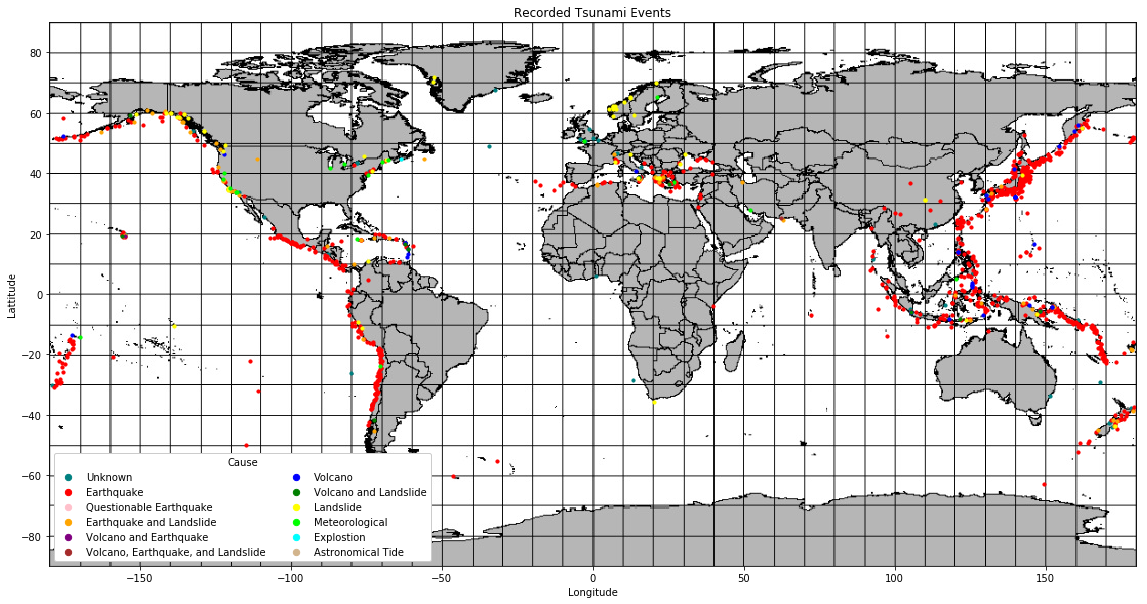

In [9]:
plot_data = TsunamiData[TsunamiData['LONGITUDE']<179.9]
plot_data = plot_data[plot_data['LONGITUDE']>-179.9]

fig, ax = plt.subplots(figsize = (20,10))
im = plt.imread('WorldMap.jpg')
ax.imshow(im, extent = [-180, 180, -90, 90])

cause_name = ['Unknown', 'Earthquake', 'Questionable Earthquake', 'Earthquake and Landslide',
             'Volcano and Earthquake', 'Volcano, Earthquake, and Landslide', 'Volcano',
             'Volcano and Landslide', 'Landslide', 'Meteorological', 'Explostion',
             'Astronomical Tide']
cause_color = ['teal', 'red', 'pink', 'orange', 'purple', 'brown', 'blue', 'green', 'yellow', 'lime', 'cyan', 'tan']
for i in [0,1,2,3,4,5,6,7,8,9,10,11]:
    ax.scatter(plot_data[plot_data['CAUSE_CODE'] == i]['LONGITUDE'], 
               plot_data[plot_data['CAUSE_CODE'] == i]['LATITUDE'], 
               c = cause_color[i], s = 10, label = cause_name[i])

plt.xlabel('Longitude')
plt.ylabel('Lattitude')
plt.title('Recorded Tsunami Events')
plt.legend(title = 'Cause', ncol = 2, framealpha = 1, markerscale =2)
plt.show()

## Tsunami Frequency vs Temperature
In the following graphs, we collected data of global temparature and the frequency of tsunamis for different years. Here, we intended to look at the most recent years to figure out if there is a correlation between global temperature and tsunami frequency

In [10]:
#read temperature data
df_temp = pd.read_json("globalTemp.json")

#trim temperature data to years in range 1993 - 2016
df_temp = df_temp.loc[(df_temp['Year'] >= 1993) & (df_temp['Year'] <= 2016) & (df_temp['Source'] == 'GCAG')]

### Graph of temperature data over time
Just to visualize the behavior of temperature over past 23 years

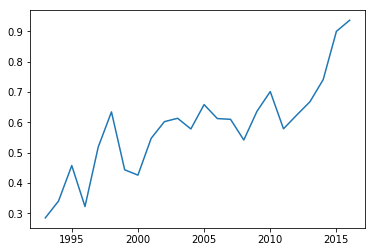

In [11]:
plt.plot(df_temp['Year'], df_temp['Mean'])

In [12]:
#read tsunami data
df_tsunami = pd.read_csv("TsunamiData.csv", encoding = 'latin')

#trim tsunami data to years in range 1993 - 2016
df_tsunami  = df_tsunami.loc[(df_tsunami['YEAR'] >= 1993) & (df_tsunami['YEAR'] <= 2016)]

In [13]:
#rearrange tsunami data to have per year rows 
count, year = np.histogram(df_tsunami['YEAR'], bins=23)
year = year[:-1]
d = {'Year': [int(i) for i in year], 'Times': count}

#create df_tsunamiCount
df_tsunamiCount = pd.DataFrame(data = d)

### Graph of number of tsunamis over time
Just to visualize the behavior of tsunami frequency over past 23 years

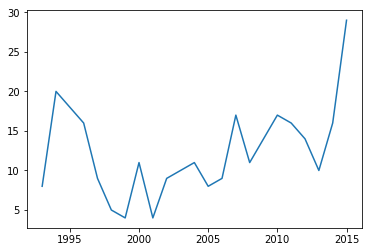

In [14]:
plt.plot(df_tsunamiCount['Year'], df_tsunamiCount['Times'])

### Graph of Number of tsunamis and Temperature
Final graph to show us how Tsunami frequency relates to temperature

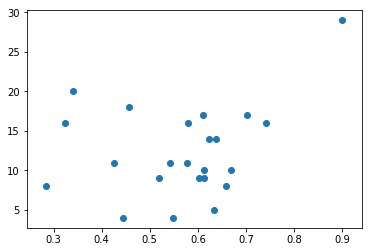

In [15]:
#merge dataframes
df_tempAndTsunami = pd.merge(df_tsunamiCount, df_temp)

plt.scatter(df_tempAndTsunami['Mean'], df_tempAndTsunami['Times'])

## Analysis on Tsunami Frequency vs Temperature

The graph above shows that there is little to no correlation between global temperature and the number of tsunamis that occur for a particular year. We hypothesized that for a particular year, a higher temperature would yield a greater number of tsunamis that took place. Even though we only had data for the past 23 years across all our datasets found online, we still expected to see an overall positive linear trend, but we were wrong.

In the past 23 years, temperature seemed to show an upward trend, while the number of tsunamis fluctuated without any sign of correlation.

A possible explanation for this lack of consistency is that tsunami frequency might still depend on temperature at least a little, but there are other factors that have a much larger effect. For example, earthquakes, and various random weather patterns. 

## Analysis of Tsunami Data in relation to Sea Level Data

One of the effects of global warming is the rising sea level. In this section, we see how global warming, by means of sea level, may be correlated to tsunami strength and frequency.

### Tsunami Strength vs Sea Level

The following section takes a look at how sea level may relate to tsunami frequency around the world. The graph below charts sea level rise since 1993 as taken from climate.nasa.gov. 

,alt type,year+fraction,# observations,# weighted observations,smoothed w/ sig removed GMSL,SD of GMSL,dif(mm)
0,0,1993.011526,466462,337277.00,-37.55,92.66,0.00
1,0,1993.038692,460889,334037.31,-38.06,95.39,-0.51
2,0,1993.065858,472123,342416.09,-37.60,92.29,-0.05
3,0,1993.093025,421377,306050.59,-37.45,96.19,0.10
4,0,1993.120191,459548,331094.09,-36.44,94.63,1.11


Text(0.5, 1.0, 'Sea Level Rise since 1993')

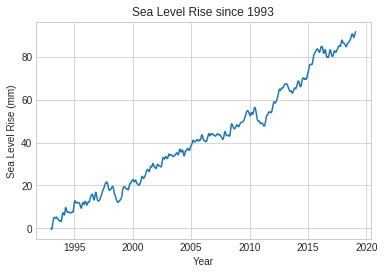

In [16]:
display(s.head())

plt.style.use('seaborn-whitegrid')

fig = plt.figure()
ax = plt.axes()

ax.plot(s['year+fraction'], s['dif(mm)'])
ax.set_xlabel('Year')
ax.set_ylabel('Sea Level Rise (mm)')
ax.set_title('Sea Level Rise since 1993')

This next part merges the sea level data with the tsunami data for futher analysis. 

In [17]:
sub = pd.read_csv("TsunamiData.csv", encoding = 'latin')
sub = sub[sub['YEAR'] >= 1993]
sub = sub.dropna(subset=['YEAR', 'DAY'])

for index, row in sub.iterrows():
    frac = int(row['YEAR']) + int(row['MONTH'])/12 + int(row['DAY'])/(30*12)
    ind = s[s['year+fraction'] > frac]['year+fraction'].idxmin
    sub.loc[index, 'dif(mm)'] = s.loc[ind,'dif(mm)']

sub_wh = sub.dropna(subset=['MAXIMUM_WATER_HEIGHT', 'PRIMARY_MAGNITUDE'])
sub_wh = sub_wh[['I_D', 'YEAR', 'MONTH', 'DAY', 'PRIMARY_MAGNITUDE','MAXIMUM_WATER_HEIGHT', 'dif(mm)']]
display(sub_wh.head())


,I_D,YEAR,MONTH,DAY,PRIMARY_MAGNITUDE,MAXIMUM_WATER_HEIGHT,dif(mm)
2324,2215,1993,2.0,7.0,6.3,0.50,4.05
2326,2218,1993,6.0,8.0,7.5,0.10,4.70
2328,2219,1993,7.0,12.0,7.7,32.00,4.12
2329,2220,1993,8.0,7.0,6.3,0.16,3.59
2330,2221,1993,8.0,8.0,7.8,2.40,3.59


The following graph plots the primary magnitude of tsunamis to their maximum water height. Although there is somewhat of a positive trend, maximum water height seems mostly independent of primary magnitude as seen by correlation coefficients closer to 0. Because of this, we decided to use maximum water height as our measure of tsunami strength as opposed to primary magnitude. 

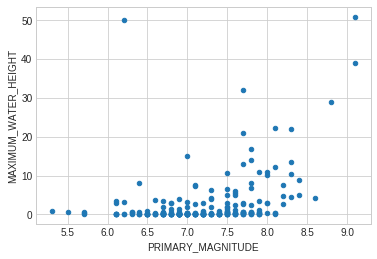

In [18]:
ax0 = sub_wh.plot.scatter(x='PRIMARY_MAGNITUDE', y='MAXIMUM_WATER_HEIGHT')

In [19]:
mag = sub_wh[['PRIMARY_MAGNITUDE']]
wh = sub_wh[['MAXIMUM_WATER_HEIGHT']]

np.corrcoef(mag.T,wh.T)

array([[ 1.        ,  0.36844662],
       [ 0.36844662,  1.        ]])

The following graphs show the relationship between sea level difference and the maximum water height which we use as a measure of tsunami strength (the stronger the tsunami, the higher the water). 

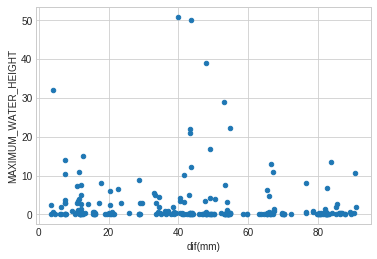

In [20]:
ax1 = sub_wh.plot.scatter(x='dif(mm)', y='MAXIMUM_WATER_HEIGHT')

There appears to be no correlation at all between sea level height and tsunami strength as seen in the mostly horizontal trend in the data above. This refutes our hypothesis that global warming may be correlated to an increase in tsunami strength.

### Tsunami Frequency vs Sea Level

The following section analyzes tsunami frequency with sea level. The following graph shows that there may be a positive correlation between yearly tsunami frequency and mean sea level rise within the year. 

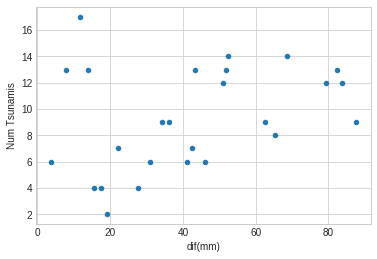

In [21]:
year_dict = {}

for index, row in sub_wh.iterrows():
    year = int(row['YEAR'])
    if year in year_dict:
        year_dict[year] = year_dict[year]+1
    else:
        year_dict[year] = 1
    
s['YEAR_whole'] = np.floor(s['year+fraction'])

year_avg = {}
for year in year_dict:
    year_avg[year] = s[s['YEAR_whole'] == year]['dif(mm)'].mean()
    
yearly = pd.DataFrame.from_dict(year_dict, orient='index')
yearly.columns=['Num Tsunamis']
yearly_dif = pd.DataFrame.from_dict(year_avg, orient='index')
yearly_dif.columns=['dif(mm)']
# display(yearly.head())
# display(yearly_dif.head())

yearly = yearly.join(yearly_dif, how='outer')

ax3 = yearly.plot.scatter(x='dif(mm)', y='Num Tsunamis')

In [22]:
tsu = yearly[['Num Tsunamis']]
sl = yearly[['dif(mm)']]
st_tsu, p_tsu = normaltest(tsu)
st_sl, p_sl = normaltest(sl)

print("tsu: st p = ", st_tsu, p_tsu)
print("sl: st p = ", st_sl, p_sl)

outcome, predictors = patsy.dmatrices('tsu ~ sl', yearly)
mod_1 = sm.OLS(outcome, predictors)
res_1 = mod_1.fit()

print(res_1.summary())

tsu: st p =  [ 2.29854162] [ 0.31686774]
sl: st p =  [ 2.52303965] [ 0.28322325]
                            OLS Regression Results                            
Dep. Variable:                    tsu   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     2.826
Date:                Sun, 09 Jun 2019   Prob (F-statistic):              0.106
Time:                        23:56:43   Log-Likelihood:                -70.567
No. Observations:                  26   AIC:                             145.1
Df Residuals:                      24   BIC:                             147.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

Although there appears to be a positive trend in the graph, a linear regression test shows that this trend is not significant (P>|t| is over 0.05). Sea level rise does not appear to be a significant contributor to the increasing frequency of tsunamis. This refutes our hypothesis that global warming may be correlated to an increase in the number of tsunamis.

# Ethics & Privacy

We don’t think that there are any privacy issues regarding our data science question(s) because the data involved doesn’t have to do with any specific party or person, but there are various ethical considerations to take into account. 

First, the data we are using is from public and government data which may have an agenda of its own. Additionally, the accuracy and collection of data could be biased towards those who have access to technology and funding. Furthermore, if we find that there is no correlation, people could take that data and use it as a reason to neglect the warnings about global warming and the earth. 

# Conclusion & Discussion

From the data, our hypothesis was not confirmed. Instead, from our data analysis, we have found that there is no correlation between global warming and tsunami frequency. As our data shows, while global temperature as been on an upward trend, the number of tsunamis has fluctuated. In terms of tsunami strength, we considered wave height  as the factor that determines the strength of a tsunami. Once again, we did not find any correlation between increase in global warming and tsunami strength.   

In terms of our data limitations, the data we looked at might not be the best determiner due to the limitations of measurement technology. Instruments to measure tsumnamis are better now than they were a long time ago, and  our data goes very far back in time. Therefore, it's possible that records of tsunamis in the past may not be very accurate. Additionally, it is important to consider that not all tsunamis are successfully recorded, which could also affect our data and the accuracy of our analysis. Finally, the clasification of what is and isn't a tsunami varies based on the location. Therefore, what would be classified as a tsunami in one location may not be in another. 